# Multiclass text classification using BERT
- toc: true
- badges: true
- categories: [Natural Language Processing, Hugging Face]
- permalink: /bert-multiclass-text-classification/
- description: a tutorial on mult-class text classfication using pretrained BERT model from HuggingFace

In this post, we'll do a simple text classification task using the pretained [BERT model]((https://huggingface.co/docs/transformers/model_doc/bert) from HuggingFace.

The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805), by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.


In [2]:
#hide
#!pip install transformers
import pandas as pd


In [ ]:
#hide
import warnings
warnings.filterwarnings("ignore")

## Loading data



In [ ]:

PRETRAINED_LM = "aubmindlab/bert-large-arabertv2"
%mkdir PRI_CATiB
TB_path="/content/PRI_CATiB"

mkdir: cannot create directory ‘PRI_CATiB’: File exists


In [ ]:
BATCH_SIZE = 16


In [3]:
def build_data(in_file,POS):

    import csv

    max_length=0

    # Open the input file in read mode
    input_file = open(in_file+".conllu", "r")

    # Create an empty list to store the lines
    words = ""
    root= ""
    csv_line=[]



    with open(in_file+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["text","label"])
        root_found=False
        # Loop through each line in the input file
        c=0
        for line in input_file:

          if line!="\n":
                words=words+(line.split()[1])+" "
                if line.split()[6]=="0" and not root_found:
                  root=POS[line.split()[3]]
                  root_found=True

          else:
                c+=1
                full_text=words[0:-1]
                root_found=False
                if len(words)>max_length: max_length= len(words.split(" "))
                csv_line.append(full_text)
                csv_line.append(str(root))
                writer.writerow(csv_line)


                csv_line=[]
                words = ""
                root= ""

    print('max_length',max_length,"\n","count of examples:",c)
    # Close the input file
    input_file.close()




In [4]:

POS={}
label_names=set()

for f in ["train","dev","test"]:
   temp_pos=set()
   input_file = open(f+".conllu", "r")
   for line in input_file:
    if line!="\n":
      if line.split()[6]=="0":
        label_names.add(line.split()[3])
        temp_pos.add(line.split()[3])
   print(f,len(temp_pos),"\n",temp_pos)

label_names=list(label_names)
for i in range(len(label_names)):
  POS[label_names[i]]=i



build_data("/content/train",POS)
build_data("/content/dev",POS)
build_data("/content/test",POS)


N_labels = len(label_names)
print(POS)
print(label_names)
print("N_labels: ",N_labels)

train_df=pd.read_csv("train.csv")
valid_df=pd.read_csv("dev.csv")
test_df=pd.read_csv("test.csv")



def count_pos(df,df_name):
    print("\n ---", df_name,"---\n")
    for i in range(N_labels):
        counter = len(df.loc[df['label'] == i])
        print(i,counter)

count_pos(train_df,"train")
count_pos(valid_df,"dev")
count_pos(test_df,"test")

train 6 
 {'VRB-PASS', 'NOM', 'VRB', 'PRT', 'PROP', 'PNX'}
dev 5 
 {'VRB-PASS', 'NOM', 'VRB', 'PRT', 'PROP'}
test 5 
 {'VRB-PASS', 'NOM', 'VRB', 'PRT', 'PNX'}
max_length 58 
 count of examples: 2099
max_length 93 
 count of examples: 264
max_length 53 
 count of examples: 228
{'VRB-PASS': 0, 'NOM': 1, 'VRB': 2, 'PRT': 3, 'PROP': 4, 'PNX': 5}
['VRB-PASS', 'NOM', 'VRB', 'PRT', 'PROP', 'PNX']
N_labels:  6

 --- train ---

0 88
1 179
2 1710
3 109
4 5
5 8

 --- dev ---

0 7
1 11
2 225
3 20
4 1
5 0

 --- test ---

0 7
1 51
2 157
3 12
4 0
5 1


In [ ]:
train_df.head()

,text,label
0,"30 . قدرت دراسة أوردت ها "" المؤسسة العربية ل ض...",2
1,31 . و لفتت الدراسة إلى أن ه يوجد في المملكة ا...,2
2,32 . و في الدول العربية الأخرى تقدر الدراسة حج...,2
3,و لاحظت المؤسسة العربية ل ضمان الٱستثمار أن مع...,0
4,33 . لكن المؤسسة لفتت إلى أن الإصلاحات الٱقتصا...,2


## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='aubmindlab/bert-large-arabertv2', vocab_size=64000, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

define a function for encoding:

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

Use the `ecode` function to get input ids and attention masks of the datasets:

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

We'll use pytorch `Dataset` and `DataLoader` to split data into batches. For more detatils, you can check out another post on [DataLoader](https://www.intodeeplearning.com/how-to-load-datasets-from-hugging-face-datasets/).

Turn the labels into tensors:

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([2099]), torch.Size([264]), torch.Size([228]))

Create dataloaders for training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

We will initiate the  `BertForSequenceClassification ` model from Huggingface, which allows easily fine-tuning the pretrained BERT mode for classification task.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

An **optimizer** is for tuning parameters in the model, which is set up with a learning rate.

Selection of the learning rate is important. In practice, it's common to use a **scheduler** to decrease the learning rate during training.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task.

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.8854281827807426 
17/17 val loss: 0.627868759281495 
Epoch:  2


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.7233060300350189 
17/17 val loss: 0.6151602347107494 
Epoch:  3


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.6879262819208882 
17/17 val loss: 0.6657643616199493 
Epoch:  4


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.6262296071332513 
17/17 val loss: 0.7854681540937984 
Epoch:  5


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.5760857210579243 
17/17 val loss: 0.8245655350825366 
Epoch:  6


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.5375417152589018 
17/17 val loss: 0.8419172430739683 
Epoch:  7


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.49549876006715227 
17/17 val loss: 0.8651495312943178 
Epoch:  8


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.46204514846657263 
17/17 val loss: 0.8791335575720843 
Epoch:  9


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.41576715948229487 
17/17 val loss: 0.9207954021061168 
Epoch:  10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.3801576525368022 
17/17 val loss: 0.9688135552055696 
Epoch:  11


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.3570531207616582 
17/17 val loss: 1.0137001223423903 
Epoch:  12


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.33960023635264597 
17/17 val loss: 1.02096046156743 
Epoch:  13


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.32565228034262406 
17/17 val loss: 1.023689585573533 
Epoch:  14


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.3085007584004691 
17/17 val loss: 1.070154549444423 
Epoch:  15


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.28267432984924223 
17/17 val loss: 1.0910724182339275 
Epoch:  16


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.27365121243973123 
17/17 val loss: 1.1112334815894855 
Epoch:  17


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.27450211618490744 
17/17 val loss: 1.1177581031532848 
Epoch:  18


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.26620975435908995 
17/17 val loss: 1.0897185565794216 
Epoch:  19


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.26162992304924765 
17/17 val loss: 1.1080129015095093 
Epoch:  20


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.2450372175962636 
17/17 val loss: 1.123699526576435 
Epoch:  21


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.2376128016039729 
17/17 val loss: 1.137713091338382 
Epoch:  22


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.23205340001026564 
17/17 val loss: 1.1462675815119463 
Epoch:  23


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.22778474120423198 
17/17 val loss: 1.1363593681770212 
Epoch:  24


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.22801188831076477 
17/17 val loss: 1.1574767845518448 
Epoch:  25


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.21567731328788353 
17/17 val loss: 1.1984848388854195 
Epoch:  26


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.19995043809864332 
17/17 val loss: 1.180701121687889 
Epoch:  27


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.2042610412392991 
17/17 val loss: 1.1885852682239868 
Epoch:  28


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.212532046787215 
17/17 val loss: 1.189529050798977 
Epoch:  29


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.2009518848181787 
17/17 val loss: 1.1937182992696762 
Epoch:  30


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

132/132 train loss: 0.2050020249955582 
17/17 val loss: 1.1915745121591232 


You can see in the output that the training and validation losses steadily decreases in each epoch.

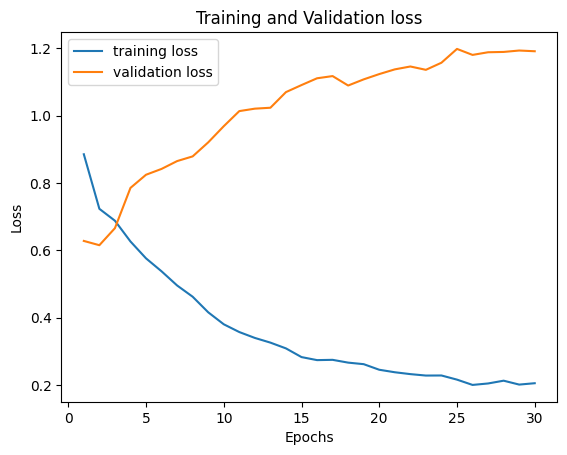

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [ ]:
from sklearn.metrics import classification_report
#print('classifiation report')
#print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

## Error Analysis
With the predictions, we can plot the confusion matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [ ]:
#plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=label_names)

You can see that **sadness** has a higher likelihood to be classified as **anger** or **fear**, leading to a lower f1 score.

<br>

## Prediction

*Now* let's use the trained model to predict the testing set.

In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
print('classifiation report\n')
print("pos count_in_pred")

for pos in set(test_pred):
  print(label_names[pos],list(test_pred).count(pos))
print("\n\npos count_in_test")
for pos in set(test_df['label'].to_numpy()):
  print(label_names[pos],list(test_df['label'].to_numpy()).count(pos))

print("\n\n Accuracy: ",round(accuracy_score(test_pred, test_df['label'].to_numpy())*100,2))
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report

pos count_in_pred
VRB 163
NOM 53
PRT 5
VRB-PASS 7


pos count_in_test
VRB 157
NOM 51
PRT 12
VRB-PASS 7
PNX 1


 Accuracy:  91.23


ValueError: ignored

With the predictions, we can plot the confusion matrix again:

ValueError: ignored

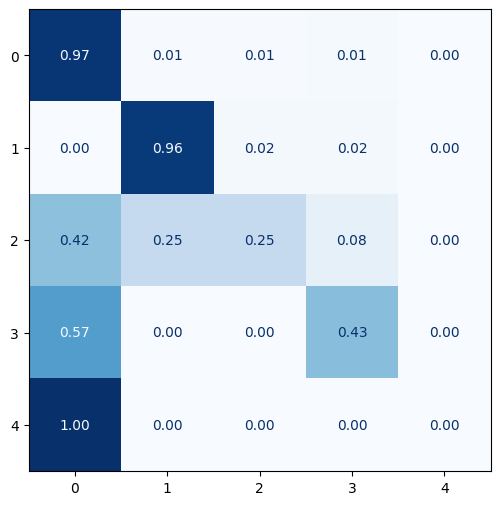

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=label_names)

Output the misclassified text:

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(20, 3)


,text,label,pred
4,لكن الحكومة أعطت هذه السنة ترخيصا ل إنشاء أول ...,3,0
13,2 ـ إن ني لا أجد تفسيرا حتى الآن ل الضعف النسب...,3,2
14,3 ـ إن الخطاب الإعلامي العربي لا يزال يتأرجح ب...,3,2
15,"4 ـ نعم . . إن مصر تسعى , و الأردن يحاول , و ا...",3,2
16,إن ني أجازف الآن ب بعض الٱجتهادات التي تعبر عن...,3,0
38,"و أقيمت أمسية عن أدب المقاومة , تحدث في ها لفي...",4,0
53,و في حال توافر هذه الفرصة في الأزمة القائمة أو...,3,0
71,"و في واقع الحال , ف إن التوصيف الوارد في غالبي...",3,0
82,و قد آن الأوان ل الٱعتراف ب حقائق لا تخفى إلا ...,0,3
93,و في حال وافق الكونجرس على الصفقة ف إن الحكومة...,3,0


In [ ]:
#hide

test_df.to_csv(TB_path+"/test_results.csv",index= False)
valid_df.to_csv(TB_path+"/dev_results.csv",index= False)

In [ ]:

from google.colab import files
%cd /content/





!zip -r PRI_CATiB.zip PRI_CATiB
files.download('PRI_CATiB.zip')


/content
  adding: PRI_CATiB/ (stored 0%)
  adding: PRI_CATiB/dev_results.csv (deflated 72%)
  adding: PRI_CATiB/test_results.csv (deflated 72%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>